In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df = pd.read_csv("Fraud.csv")

In [ ]:
df.shape

(641465, 11)

In [ ]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,diffOrg,diffDest
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0.0,0.0,9839.64,0.0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0.0,0.0,1864.28,0.0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1.0,0.0,181.00,0.0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1.0,0.0,181.00,-21182.0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0.0,0.0,11668.14,0.0


# Data Inspection

In [ ]:
df.isnull().sum()

,0
step,0
type,0
amount,0
nameOrig,0
oldbalanceOrg,0
newbalanceOrig,0
nameDest,0
oldbalanceDest,0
newbalanceDest,1
isFraud,1


In [ ]:
df.dtypes

,0
step,int64
type,object
amount,float64
nameOrig,object
oldbalanceOrg,float64
newbalanceOrig,float64
nameDest,object
oldbalanceDest,float64
newbalanceDest,float64
isFraud,float64


In [ ]:
df['isFraud'].value_counts()

,count
isFraud,
0.0,641077
1.0,387


In [ ]:
df['isFraud'].isna().sum()

np.int64(1)

In [ ]:
(df['isFraud'].value_counts(normalize=True) * 100).round(4)

,proportion
isFraud,
0.0,99.9397
1.0,0.0603


# Explortory Data Analysis

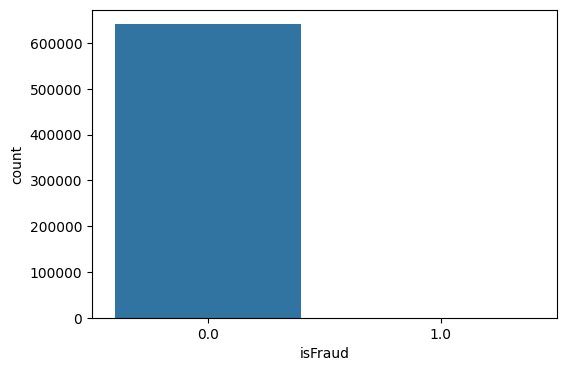

In [ ]:
# Fraud vs Non-Fraud bar plot
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='isFraud')
plt.show()

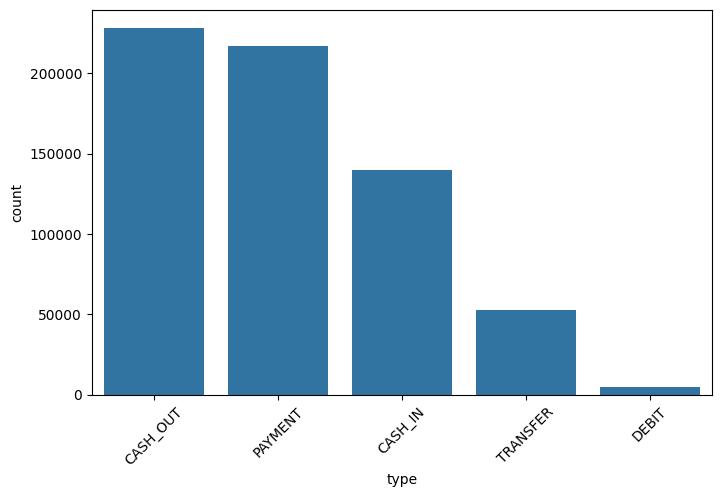

In [ ]:
# Transaction type distribution
plt.figure(figsize=(8,5))
sns.countplot(data=df, x='type', order=df['type'].value_counts().index)
plt.xticks(rotation=45)
plt.show()

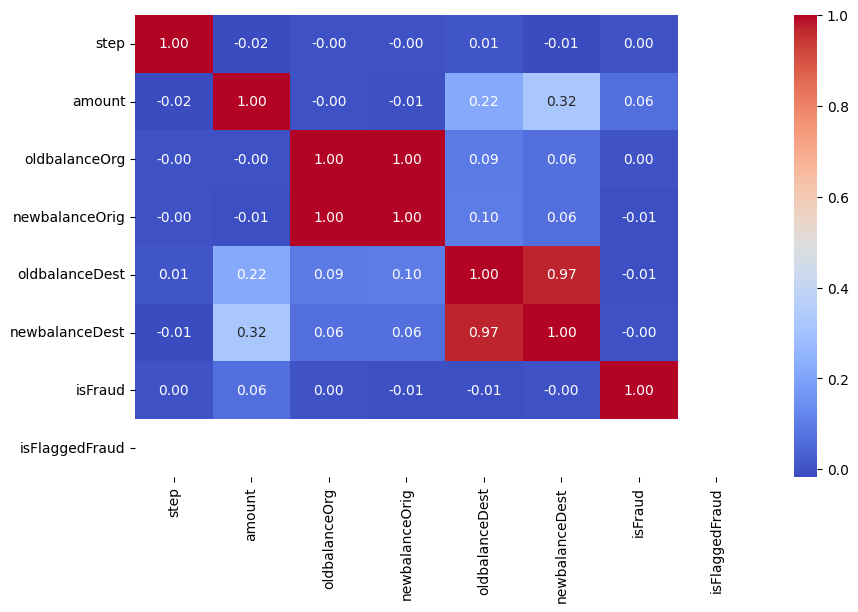

In [ ]:
# Correlation Heatmap (on numerical columns only)
numeric_df = df.drop(['nameOrig', 'nameDest', 'type'], axis=1)

plt.figure(figsize=(10,6))
sns.heatmap(numeric_df.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.show()

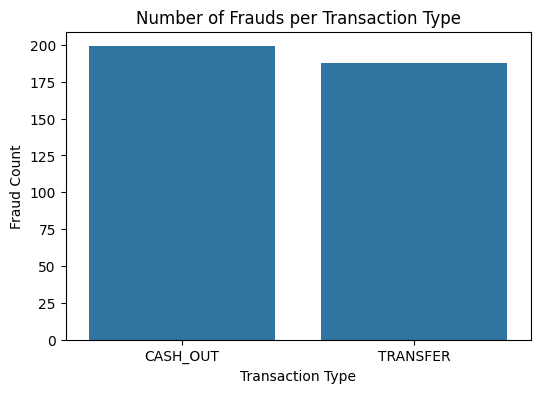

In [ ]:
# Count of frauds by transaction type
fraud_by_type = df[df['isFraud'] == 1]['type'].value_counts()

# Plot
plt.figure(figsize=(6,4))
sns.barplot(x=fraud_by_type.index, y=fraud_by_type.values)
plt.title("Number of Frauds per Transaction Type")
plt.xlabel("Transaction Type")
plt.ylabel("Fraud Count")
plt.show()

We can conclude from above that 100% fraud cases are only in CASH_OUT  and TRANSFER// which we can also conclude from normal human logical thinking

# Data Cleaning

In [ ]:
# Keep only fraud-relevant types
df = df[df['type'].isin(['TRANSFER', 'CASH_OUT'])].copy()

# Encode 'type' column manually
df['type'] = df['type'].map({'TRANSFER': 0, 'CASH_OUT': 1})

In [ ]:
print("New shape after filtering:", df.shape)
print("Encoded types (0 = TRANSFER, 1 = CASH_OUT):")

New shape after filtering: (280336, 13)
Encoded types (0 = TRANSFER, 1 = CASH_OUT):


In [ ]:
df['type'].value_counts()

,count
type,
1,227885
0,52451


In [ ]:
# Droping columns: not useful for modeling
df = df.drop(['nameOrig', 'nameDest', 'isFlaggedFraud'], axis=1)

In [ ]:
df['isFraud'].isna().sum()

np.int64(1)

In [ ]:
df = df.dropna(subset=['isFraud'])

In [ ]:
print("Final cleaned shape:", df.shape)
df.head()

Final cleaned shape: (280335, 10)


,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,diffOrg,diffDest
2,1,0,181.00,181.0,0.0,0.0,0.00,1.0,181.0,0.00
3,1,1,181.00,181.0,0.0,21182.0,0.00,1.0,181.0,-21182.00
15,1,1,229133.94,15325.0,0.0,5083.0,51513.44,0.0,15325.0,46430.44
19,1,0,215310.30,705.0,0.0,22425.0,0.00,0.0,705.0,-22425.00
24,1,0,311685.89,10835.0,0.0,6267.0,2719172.89,0.0,10835.0,2712905.89


In [ ]:
print('Number of transactions where the transaction amount is negative: ' +
str(sum(df['amount'] < 0)))

print('Number of transactions where the transaction amount is zero: ' +
str(sum(df['amount'] == 0)))

Number of transactions where the transaction amount is negative: 0
Number of transactions where the transaction amount is zero: 0


# Feature Engineering

In [ ]:
# Difference between old and new balances for origin
df['diffOrg'] = df['oldbalanceOrg'] - df['newbalanceOrig']

# Difference between new and old balances for destination
df['diffDest'] = df['newbalanceDest'] - df['oldbalanceDest']


In [ ]:
from sklearn.model_selection import train_test_split
train_data,test_data=train_test_split(df,test_size=0.2,random_state=21)

In [ ]:
train_data.shape

(224268, 10)

In [ ]:
test_data.shape

(56067, 10)

In [ ]:
x_train=train_data.drop(["isFraud"],axis=1)
y_train=train_data["isFraud"]

x_test=test_data.drop("isFraud",axis=1)
y_test=test_data["isFraud"]

# Models

## Decision Tress

In [ ]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(random_state=42)
clf.fit(x_train, y_train)

y_pred = clf.predict(x_test)

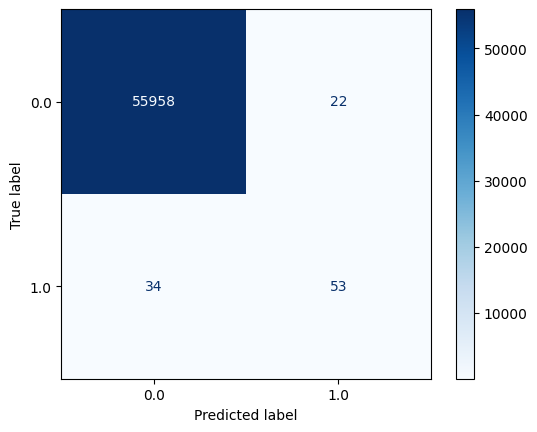

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot(cmap='Blues')
plt.show()

In [ ]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
scores = cross_val_score(clf, x_train, y_train, cv=StratifiedKFold(5), scoring='f1')
print("F1 scores:", scores)

F1 scores: [0.68333333 0.55813953 0.60655738 0.51785714 0.64      ]


## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=100, random_state=21)
rf_model.fit(x_train,y_train)

y_test_pred_rf = rf_model.predict(x_test)

Random Forest Confusion Matrix:


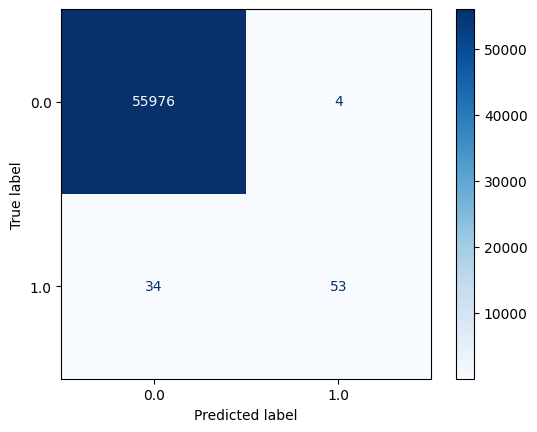

In [ ]:
cm_rf = confusion_matrix(y_test, y_test_pred_rf)
print("Random Forest Confusion Matrix:")

disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=rf_model.classes_)
disp_rf.plot(cmap='Blues')

## XGBoost

In [ ]:
import xgboost as xgb

In [ ]:
Xx = df.drop('isFraud', axis=1)
yy = df['isFraud']

In [ ]:
X_TRAIN, X_TEST, Y_TRAIN, Y_TEST = train_test_split(Xx, yy, stratify=y, test_size=0.2, random_state=42)

In [ ]:
xgb_clf = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    scale_pos_weight=(y == 0).sum() / (y == 1).sum(),  # handles imbalance
    use_label_encoder=False,
    random_state=42
)

xgb_clf.fit(X_TRAIN, Y_TRAIN)

y_pred = xgb_clf.predict(X_TEST)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:41:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     55990
         1.0       0.68      0.82      0.74        77

    accuracy                           1.00     56067
   macro avg       0.84      0.91      0.87     56067
weighted avg       1.00      1.00      1.00     56067



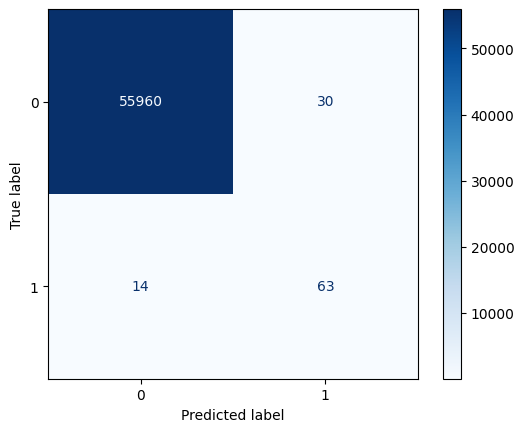

In [ ]:
cm = confusion_matrix(Y_TEST, y_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot(cmap='Blues')

print("Classification Report:")
print(classification_report(Y_TEST, y_pred))

## Logistic Regression

Scaling for logistic regression, along with some feature engineering

In [ ]:
data = df.copy()

data['amountToOrigBalance'] = df['amount'] / (df['oldbalanceOrg'] + 1)
data['amountToDestBalance'] = df['amount'] / (df['newbalanceDest'] + 1)

data = data.drop(['oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest'], axis=1)

In [ ]:
data.head()

,step,type,amount,isFraud,diffOrg,diffDest,amountToOrigBalance,amountToDestBalance
2,1,0,181.00,1.0,181.0,0.00,0.994505,181.000000
3,1,1,181.00,1.0,181.0,-21182.00,0.994505,181.000000
15,1,1,229133.94,0.0,15325.0,46430.44,14.950668,4.447956
19,1,0,215310.30,0.0,705.0,-22425.00,304.972096,215310.300000
24,1,0,311685.89,0.0,10835.0,2712905.89,28.763925,0.114625


In [ ]:
data = data.sort_values('step').reset_index(drop=True)

In [ ]:
data.head()

,step,type,amount,isFraud,diffOrg,diffDest,amountToOrigBalance,amountToDestBalance
0,1,0,554026.99,0.0,0.0,-579285.56,554026.99,554026.990000
1,1,0,1505626.01,0.0,0.0,5486732.34,1505626.01,0.272968
2,1,0,379856.23,0.0,0.0,18269024.93,379856.23,0.019816
3,1,0,125872.53,0.0,0.0,3071591.09,125872.53,0.036804
4,1,0,224606.64,0.0,0.0,-354678.92,224606.64,224606.640000


In [ ]:
X = data.drop('isFraud', axis=1)
y = data['isFraud']

In [ ]:
X_Train, X_Test, Y_Train, Y_Test = train_test_split(X, Y, stratify=y, random_state=42, test_size=0.2)

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
x_train_scaled = scaler.fit_transform(X_Train)
x_test_scaled = scaler.transform(X_Test)

In [ ]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
log_reg.fit(x_train_scaled, y_train)

y_pred_log = log_reg.predict(x_test_scaled)


Logistic Regression Confusion Matrix:


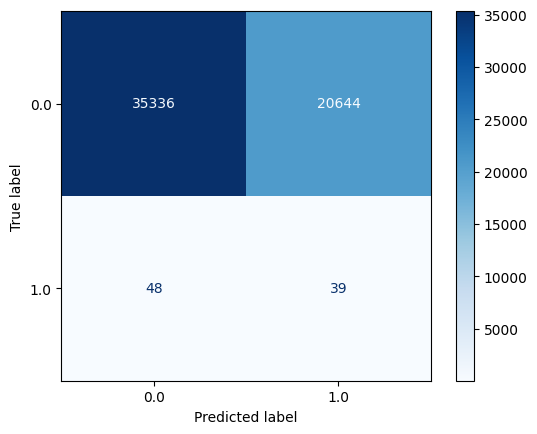

In [ ]:
cm_log = confusion_matrix(y_test, y_pred_log)
print("Logistic Regression Confusion Matrix:")

disp_log = ConfusionMatrixDisplay(confusion_matrix=cm_log, display_labels=log_reg.classes_)
disp_log.plot(cmap='Blues')